In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
def get_mrs_fitness(x, mrs, optim_fn, n_samples=None):
    for _ in range(x.ndim):
        mrs = mrs[..., None]
    shape = list(x.shape)
    if n_samples is not None:
        shape = [n_samples] + shape
        mrs = mrs[..., None]
    xmut = x+torch.randn(shape).to(x)*mrs
    fit_diff = optim_fn(xmut) - optim_fn(x)
    return x, xmut, fit_diff

def get_optimal_mr_extreme(x, mrs, optim_fn, n_samples=None):
    x, xmut, fit_diff = get_mrs_fitness(x, mrs, optim_fn, n_samples)
    return mrs[fit_diff.min(dim=-1).values.argmin(dim=0)]

def get_optimal_mr_look_ahead(x, mrs, optim_fn, n_gen=10, n_samples=1):
    if x.ndim==2:
        x = x[None]
    f = []
    for xi in x:
        for mr in mrs:
            for i in range(n_samples):
                pops, fits = optim.run_evolution_base(xi, optim_fn, n_gen, mr=mr)
                f.append(fits.min())
    f = torch.stack(f).reshape(len(x), len(mrs), n_samples)
    return mrs[f.mean(dim=-1).argmin(dim=-1)]

<ipython-input-292-fdb79787b484>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


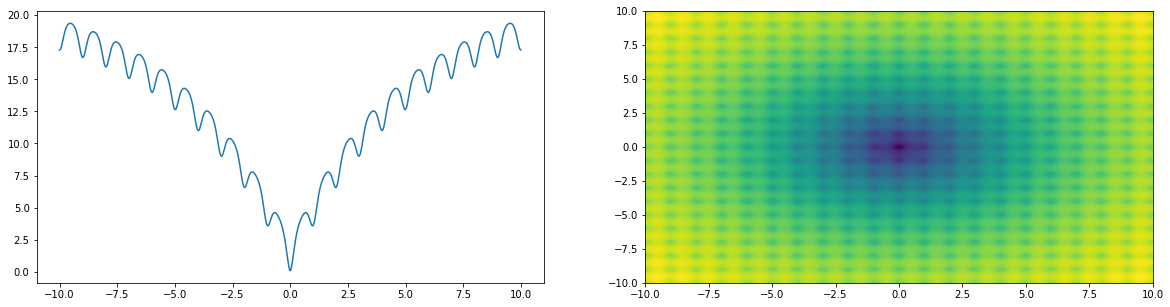

<ipython-input-292-fdb79787b484>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


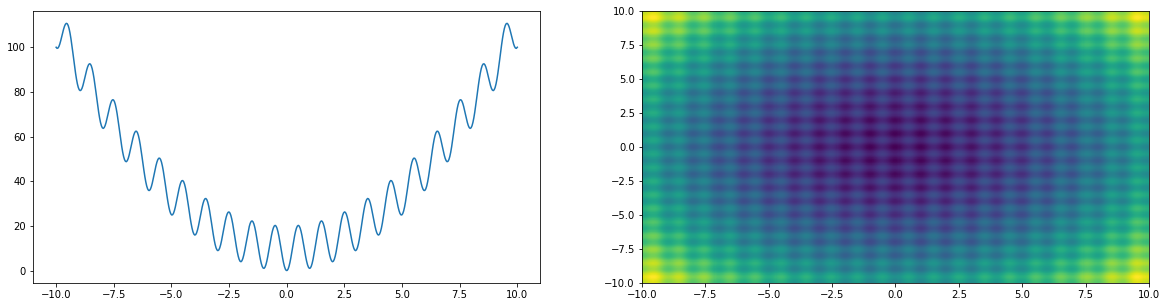

<ipython-input-292-fdb79787b484>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


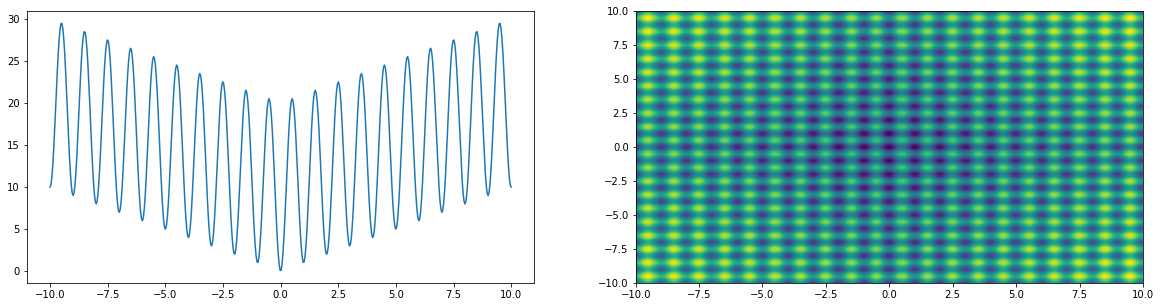

<ipython-input-292-fdb79787b484>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


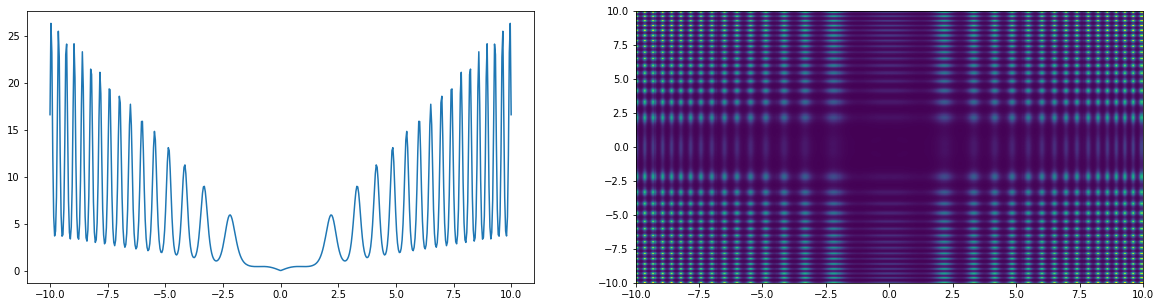

<ipython-input-292-fdb79787b484>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


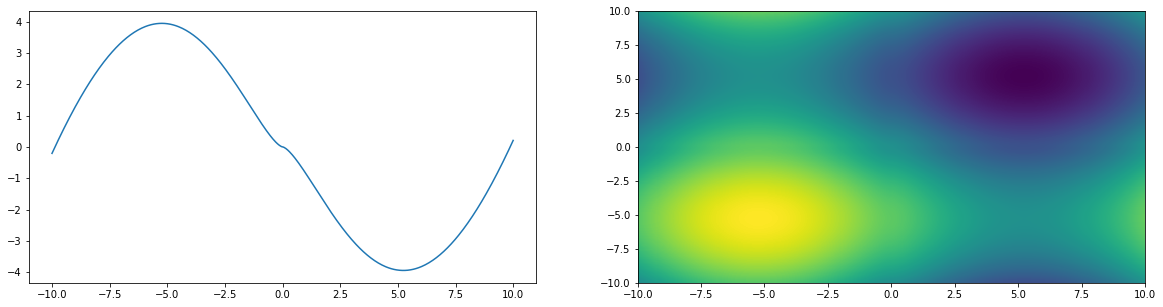

<ipython-input-292-fdb79787b484>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


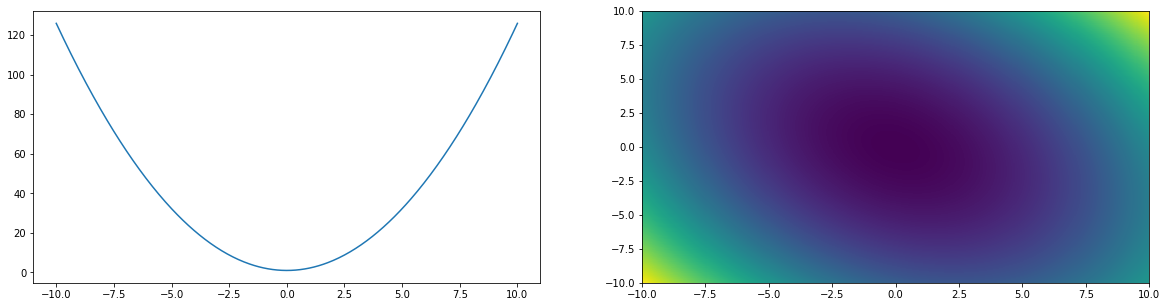

<ipython-input-292-fdb79787b484>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


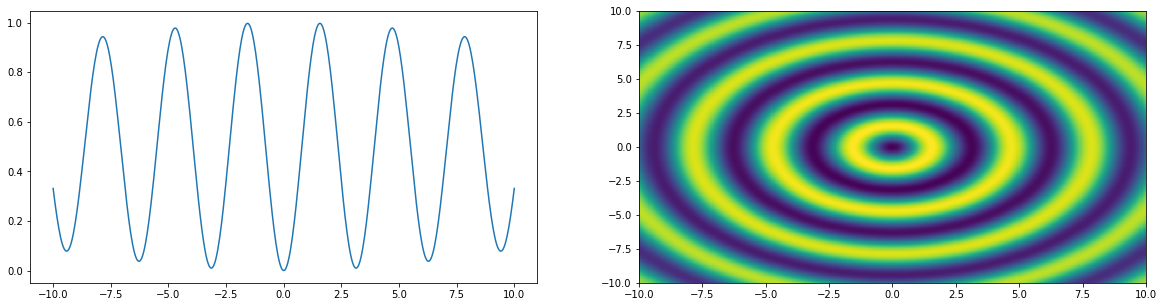

In [292]:
x = torch.linspace(-10, 10, 500)
y = torch.linspace(-10, 10, 500)
# x = torch.linspace(-500, 500, 1000)
# y = torch.linspace(-500, 500, 1000)
xm, ym = torch.meshgrid(x, y)

for optim_fn in [ackley, rastrigin, myrastrigin, xin_she_yang, schwefel, zakharov, schaffer]:
    plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.plot(x, optim_fn(x[:, None]))
    plt.subplot(122)
    z = torch.stack([xm, ym], dim=-1)
    z = optim_fn(z)
    plt.pcolormesh(x, y, z)
    plt.show()
    

In [5]:
import optim

100%|██████████| 5/5 [00:28<00:00,  5.67s/it]


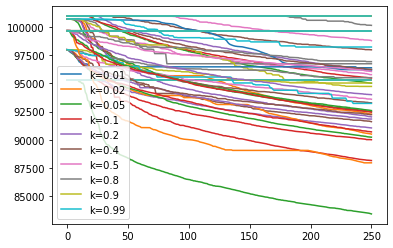

In [50]:
for i in tqdm(range(5)):
    do_seed(i)
    pop = torch.randn(101, 1000)*10.
    for k in [.01, .02, .05, .1, .2, .4, .5, .8, .9, .99]:
        pops, fits_ns, mrs_ns = optim.run_evolution_ns(pop, optim_fn, n_gen//2, mr_mut=2.0, k=k)
        plt.plot(fits_ns.min(dim=-1).values, label=f'k={k}' if i==0 else None)
    plt.gca().set_prop_cycle(None)
plt.legend()

100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


(0.0, 100000.0)

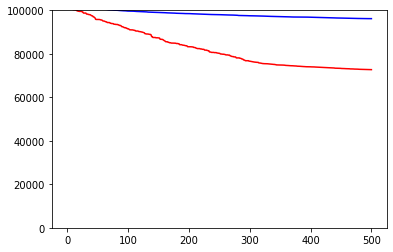

In [31]:
optim_fn = rastrigin
n_gen = 500
k=.5
for i in tqdm(range(1)):
    do_seed(i)
    pop = torch.randn(101, 1000)*10.

    pops, fits_ns, mrs_ns = optim.run_evolution_ns(pop, optim_fn, n_gen, mr_mut=2.0, k=k)
    plt.plot(fits_ns.min(dim=-1).values, color='b')
    
    pops, fits_ours, mrs_ours, _ = optim.run_evolution_ours(pop, optim_fn, n_gen, n_mutpop=10, mr_mut=2., k=k)
    plt.plot(fits_ours.min(dim=-1).values, color='r')
plt.ylim(0, 1e5)



In [34]:
from tqdm.notebook import tqdm

In [ ]:
pop = torch.randn(n_pop, n_dim)*init_pop_var

ofmr_mrs = torch.logspace(log_mr_low, log_mr_high, n_mrs)
la_mrs = torch.logspace(log_mr_low, log_mr_high, n_mrs)

mr_1c = torch.tensor(1./pop.shape[-1])
pops, fits_1c = optim.run_evolution_base(pop, optim_fn, n_gen, mr=mr_1c, k=k)
data['1CMR']['fits'].append(fits_1c); data['1CMR']['mrs'].append(mr_1c.repeat(n_gen+1, 1))

pops_ofmr, fits_ofmr = optim.run_evolution_ofmr(pop, ackley, 50, torch.logspace(-3, 1, 5), n_sample=2)
data['OFMR']['fits'].append(fits_ofmr); data['OFMR']['mrs'].append(ofmr.repeat(n_gen+1, 1))

pops, fits_la, mrs_la = optim.run_evolution_look_ahead(pop, optim_fn, n_gen, 
                                                 la_mrs, la_look_ahead, la_every_k, la_n_sims,
                                                 k=k)
data['LAMR']['fits'].append(fits_la); data['LAMR']['mrs'].append(mrs_la[..., None])

pops, fits_ours, mrs_ours, _ = optim.run_evolution_ours(pop, optim_fn, n_gen, n_mutpop=10, mr_mut=2., k=k)
data['GSMR']['fits'].append(fits_ours); data['GSMR']['mrs'].append(mrs_ours[..., 0])

pops, fits_ns, mrs_ns = optim.run_evolution_ns(pop, optim_fn, n_gen, mr_mut=2.0, k=k)
data['NSMR']['fits'].append(fits_ns); data['NSMR']['mrs'].append(mrs_ns[..., 0])

pops, fits_15, mrs_15 = optim.run_evolution_one_fifth(pop, optim_fn, n_gen, 1e-2, mr_mut=1.05, k=k)
data['15MR']['fits'].append(fits_15); data['15MR']['mrs'].append(mrs_15[..., None])



In [354]:
algos = ['ofmr', 'lamr_10', 'lamr_100', '1cmr', '15mr', 'ucb_5', 'ucb_10', 'nsmr', 'gsmr']
labels = ['OFMR', 'LAMR-10', 'LAMR-100', '1CMR', '15MR', 'UCB/5', 'UCB/10', 'NSMR', 'GSMR']
colors = ['cornflowerblue', 'olive', 'yellow', 'brown', 'orange', 'magenta', 'magenta', 'green', 'red']
algo2color = {algo: color for algo, color in zip(algos, colors)}
algo2label = {algo: label for algo, label in zip(algos, labels)}

In [243]:

log_mr_low, log_mr_high = -3, 0
mrs_grid_5 = torch.logspace(log_mr_low, log_mr_high, 5)
mrs_grid_10 = torch.logspace(log_mr_low, log_mr_high, 10)
mrs_grid_20 = torch.logspace(log_mr_low, log_mr_high, 20)

re_ofmr = partial(optim.run_evolution_ofmr, mrs=mrs_grid_10, n_sample=1)

re_la_10 = partial(optim.run_evolution_look_ahead, 
                    mrs=mrs_grid_10, look_ahead=10, every_k_gen=10, n_sims=1)
re_la_100 = partial(optim.run_evolution_look_ahead, 
                    mrs=mrs_grid_10, look_ahead=100, every_k_gen=100, n_sims=1)

def re_1c(pop, optim_fn, n_gen, k=.5, k_elite=None):
    mr = torch.tensor(1./pop.shape[-1]).to(pop)
    a = optim.run_evolution_base(pop, optim_fn, n_gen, mr, k=k, k_elite=k_elite)
    return *a, mr.repeat(n_gen+1)

re_15 = partial(optim.run_evolution_one_fifth, 
                mr=1e-2, mr_mut=1.01, thresh=0.2)

re_ucb_5 = partial(optim.run_evolution_ucb, mrs=mrs_grid_5)
re_ucb_10 = partial(optim.run_evolution_ucb, mrs=mrs_grid_10)

re_nsmr = partial(optim.run_evolution_ns,
                  mr=None, mr_mut=2.0)

re_gsmr = partial(optim.run_evolution_ours, 
                  n_mutpop=10, mr=None, mr_mut=2.0)

algo_fns = [re_ofmr, re_la_10, re_la_100, re_1c, 
            re_15, re_ucb_5, re_ucb_10, re_nsmr, re_gsmr]
algo2algo_fn = {algo: algo_fn for algo, algo_fn in zip(algos, algo_fns)}

  0%|          | 0/9 [00:00<?, ?it/s]

In [266]:
optim_fns = [ackley, rastrigin]
optim_fns = [ackley]
n_dims = [2, 30, 100, 1000]
n_dims = [30]
init_pop_vars = [.1, 1, 5, 10]
init_pop_vars = [5]
n_seed = 5
n_gen = 500
n_pop = 101

data = np.zeros((len(algos), len(optim_fns), len(n_dims), 
                 len(init_pop_vars), n_seed, n_gen+1, 2))
data = xr.DataArray(data, dims=('algo', 'optim_fn', 'n_dim', 
                                'init_pop_var', 'seed', 'gen', 'fits_mrs'),
                    coords={'algo': algos, 
                            'optim_fn': optim_fns,
                            'n_dim': n_dims,
                            'init_pop_var': init_pop_vars,
                            'seed': list(range(n_seed)),
                            'gen': list(range(n_gen+1)),
                            'fits_mrs': ['fits', 'mrs'],
                           })

pbar = tqdm(total=len(optim_fns)*len(n_dims)*len(init_pop_vars)*n_seed*len(algos))
for optim_fn in optim_fns:
    for n_dim in n_dims:
        for init_pop_var in init_pop_vars:
            for seed in range(n_seed):
                for algo in algos:
                    res = algo2algo_fn[algo](torch.randn(n_pop, n_dim), ackley, n_gen)
                    pops, fits, mrs = res[:3]
                    fits = fits.min(dim=-1).values
                    while mrs.ndim>1:
                        mrs = mrs.log().mean(dim=-1).exp()
                    
                    a = data.sel(algo=algo, optim_fn=optim_fn, n_dim=n_dim, 
                                 init_pop_var=init_pop_var, seed=seed)
                    
                    a.sel(fits_mrs='fits')[:] = fits.detach().cpu().numpy()
                    a.sel(fits_mrs='mrs')[:] = mrs.detach().cpu().numpy()
            
                    pbar.update(n=1); pbar.refresh()

  0%|          | 0/720 [00:00<?, ?it/s]

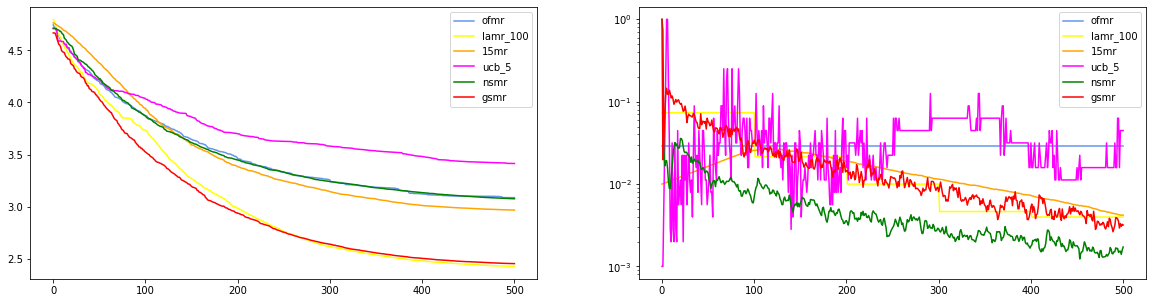

In [291]:
algos_render = ['ofmr', 'lamr_100', '15mr', 'ucb_5', 'nsmr', 'gsmr']
plt.figure(figsize=(20,5))
plt.subplot(121)
for algo in algos_render:
    a = data[:, 0, 2, 1, :, :, 0].sel(algo=algo)
    viz.plot_mean_std(torch.from_numpy(a.data), algo, algo2color[algo], False, 
                      render_mean=True, render_std=False, render_plots=False)
plt.subplot(122)
for algo in algos_render:
    a = data[:, 0, 2, 1, :, :, 1].sel(algo=algo)
    viz.plot_mean_std(torch.from_numpy(a.data), algo, algo2color[algo], True, 
                      render_mean=True, render_std=False, render_plots=False)

In [308]:
data.dims

('algo', 'optim_fn', 'n_dim', 'init_pop_var', 'seed', 'gen', 'fits_mrs')

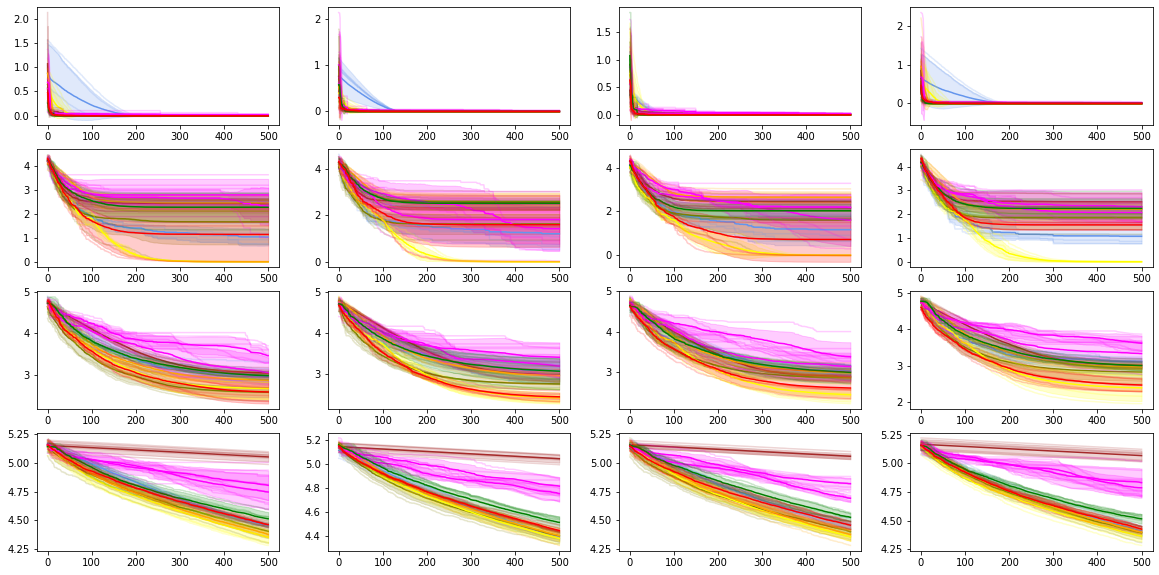

In [335]:
for optim_fn in data.coords['optim_fn']:
    plt.figure(figsize=(20, 10))
    i=1
    for n_dim in data.coords['n_dim']:
        for init_pop_var in data.coords['init_pop_var']:
            plt.subplot(len(n_dims), len(init_pop_vars), i)
            i+=1
            for algo in data.coords['algo']:
                algo = str(algo.data)
                a = data.sel(algo=algo, optim_fn=optim_fn, 
                             n_dim=n_dim, init_pop_var=init_pop_var)
                b = torch.from_numpy(a.sel(fits_mrs='fits').data).float()
                viz.plot_mean_std(b, algo2label[algo], algo2color[algo])
            plt.gca().get_legend().remove()



In [353]:
for optim_fn in data.coords['optim_fn']:
    for n_dim in data.coords['n_dim']:
        for init_pop_var in data.coords['init_pop_var']:
            for algo in data.coords['algo']:
                algo = str(algo.data)
                a = data.sel(algo=algo, optim_fn=optim_fn, 
                             n_dim=n_dim, init_pop_var=init_pop_var,
                             gen=n_gen,)
                a = a.sel(fits_mrs='fits').mean(dim='seed')
                print(f'{algo}: {a.data:.03f}')
            print()
    

ofmr: 0.000
lamr_10: 0.000
lamr_100: 0.000
1cmr: 0.011
15mr: 0.000
ucb_5: 0.018
ucb_10: 0.020
nsmr: 0.000
gsmr: 0.000

ofmr: 0.000
lamr_10: 0.000
lamr_100: 0.000
1cmr: 0.007
15mr: 0.000
ucb_5: 0.009
ucb_10: 0.014
nsmr: 0.000
gsmr: 0.000

ofmr: 0.000
lamr_10: 0.000
lamr_100: 0.000
1cmr: 0.014
15mr: 0.000
ucb_5: 0.021
ucb_10: 0.012
nsmr: 0.000
gsmr: 0.000

ofmr: 0.000
lamr_10: 0.000
lamr_100: 0.000
1cmr: 0.012
15mr: 0.000
ucb_5: 0.010
ucb_10: 0.022
nsmr: 0.000
gsmr: 0.000

ofmr: 1.037
lamr_10: 1.671
lamr_100: 0.005
1cmr: 2.430
15mr: 2.475
ucb_5: 2.801
ucb_10: 2.327
nsmr: 2.285
gsmr: 1.146

ofmr: 1.203
lamr_10: 1.625
lamr_100: 0.005
1cmr: 2.545
15mr: 2.587
ucb_5: 1.816
ucb_10: 1.422
nsmr: 2.508
gsmr: 1.588

ofmr: 1.173
lamr_10: 1.599
lamr_100: 0.006
1cmr: 2.435
15mr: 2.648
ucb_5: 1.608
ucb_10: 2.188
nsmr: 2.032
gsmr: 0.725

ofmr: 1.069
lamr_10: 1.848
lamr_100: 0.005
1cmr: 2.518
15mr: 2.208
ucb_5: 2.065
ucb_10: 2.313
nsmr: 2.240
gsmr: 1.550

ofmr: 2.966
lamr_10: 2.583
lamr_100: 2.672
1cmr:

51 [ 1  2  5 10 25 50]


  0%|          | 0/6 [00:00<?, ?it/s]

101 [  1   2   4   5  10  20  25  50 100]


  0%|          | 0/9 [00:00<?, ?it/s]

201 [  1   2   4   5   8  10  20  25  40  50 100 200]


  0%|          | 0/12 [00:00<?, ?it/s]

401 [  1   2   4   5   8  10  16  20  25  40  50  80 100 200 400]


  0%|          | 0/15 [00:00<?, ?it/s]

601 [  1   2   3   4   5   6   8  10  12  15  20  24  25  30  40  50  60  75
 100 120 150 200 300 600]


  0%|          | 0/24 [00:00<?, ?it/s]

801 [  1   2   4   5   8  10  16  20  25  32  40  50  80 100 160 200 400 800]


  0%|          | 0/18 [00:00<?, ?it/s]

1001 [   1    2    4    5    8   10   20   25   40   50  100  125  200  250
  500 1000]


  0%|          | 0/16 [00:00<?, ?it/s]

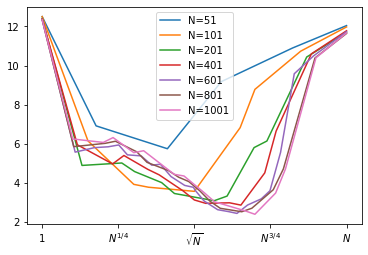

In [597]:
calc_factors = lambda x: np.array([i for i in range(1, x+1) if x%i==0])
optim_fn = ackley
n_gen = 500
n_seed = 5
n_dim = 100


# d = np.zeros((len(n_pops), len(optim_fns), len(n_dims), 
#                  len(init_pop_vars), n_seed, n_gen+1, 2))
# d = xr.DataArray(d, dims=('algo', 'optim_fn', 'n_dim', 
#                                 'init_pop_var', 'seed', 'gen', 'fits_mrs'),
#                     coords={'algo': algos, 
#                             'optim_fn': optim_fns,
#                             'n_dim': n_dims,
#                             'init_pop_var': init_pop_vars,
#                             'seed': list(range(n_seed)),
#                             'gen': list(range(n_gen+1)),
#                             'fits_mrs': ['fits', 'mrs'],
#                            })

n_pops = [51, 101, 201, 401, 601, 801, 1001]
# n_pops = [51]
for n_pop in n_pops:
    n_mutpops = calc_factors(n_pop-1)
    f = []
    print(n_pop, n_mutpops)
    for n_mutpop in tqdm(n_mutpops):
        for seed in range(n_seed):
            do_seed(seed+100)
            pop = torch.randn(n_pop, n_dim)*5
            pops, fits, mrs, _ = optim.run_evolution_ours(pop, optim_fn, n_gen, n_mutpop)
            f.append(fits)
    f = torch.stack(f).reshape(len(n_mutpops), n_seed, n_gen+1, n_pop)
    a = f.min(dim=-1).values[..., -1].T
    x = np.exp(np.log(n_mutpops)/np.log(np.max(n_mutpops)))
    plt.plot(x, a.mean(dim=0).numpy(), label=f'N={n_pop}')
ticks = np.e**np.linspace(0, 1, 5)
plt.xscale('log')
plt.gca().set_xticks(ticks)
plt.gca().set_xticklabels(['$1$', '$N^{1/4}$', '$\sqrt{N}$', '$N^{3/4}$', '$N$'])
plt.minorticks_off()
plt.legend()

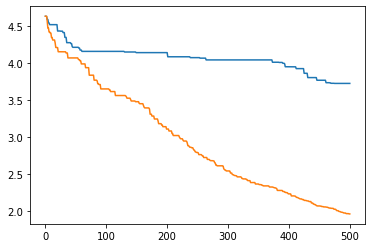

In [588]:
pop = torch.randn(1001, 10)
pops, fits, mrs, _ = optim.run_evolution_ours(pop, optim_fn, 500, n_mutpop=10)
plt.plot(fits.min(dim=-1).values)
pops, fits, mrs, _ = optim.run_evolution_ours(pop, optim_fn, 500, n_mutpop=40)
plt.plot(fits.min(dim=-1).values)

In [107]:
def run_experiment(n_pop, n_dim, init_pop_var, optim_fn, n_gen, k=.5, 
                   log_mr_low=-2.5, log_mr_high=0, n_mrs=8,
                   la_look_ahead=100, la_every_k=100, la_n_sims=3,
                   n_seeds=5):
    data = {i:{'fits': [], 'mrs': []} for i in algo_names}
    for i in tqdm(range(n_seeds)):
        do_seed(i)
        pop = torch.randn(n_pop, n_dim)*init_pop_var

        ofmr_mrs = torch.logspace(log_mr_low, log_mr_high, n_mrs)
        la_mrs = torch.logspace(log_mr_low, log_mr_high, n_mrs)
        
        mr_1c = torch.tensor(1./pop.shape[-1])
        pops, fits_1c = optim.run_evolution_base(pop, optim_fn, n_gen, mr=mr_1c, k=k)
        data['1CMR']['fits'].append(fits_1c); data['1CMR']['mrs'].append(mr_1c.repeat(n_gen+1, 1))

        ofmr, _ = optim.calc_ofmr(pop, optim_fn, n_gen, ofmr_mrs, 3)
        pops, fits_ofmr = optim.run_evolution_base(pop, optim_fn, n_gen, mr=ofmr, k=k)
        data['OFMR']['fits'].append(fits_ofmr); data['OFMR']['mrs'].append(ofmr.repeat(n_gen+1, 1))

        pops, fits_la, mrs_la = optim.run_evolution_look_ahead(pop, optim_fn, n_gen, 
                                                         la_mrs, la_look_ahead, la_every_k, la_n_sims,
                                                         k=k)
        data['LAMR']['fits'].append(fits_la); data['LAMR']['mrs'].append(mrs_la[..., None])

        pops, fits_ours, mrs_ours, _ = optim.run_evolution_ours(pop, optim_fn, n_gen, n_mutpop=10, mr_mut=2., k=k)
        data['GSMR']['fits'].append(fits_ours); data['GSMR']['mrs'].append(mrs_ours[..., 0])

        pops, fits_ns, mrs_ns = optim.run_evolution_ns(pop, optim_fn, n_gen, mr_mut=2.0, k=k)
        data['NSMR']['fits'].append(fits_ns); data['NSMR']['mrs'].append(mrs_ns[..., 0])

        pops, fits_15, mrs_15 = optim.run_evolution_one_fifth(pop, optim_fn, n_gen, 1e-2, mr_mut=1.05, k=k)
        data['15MR']['fits'].append(fits_15); data['15MR']['mrs'].append(mrs_15[..., None])

    for i in algo_names:
        data[i]['fits'] = torch.stack(data[i]['fits']).min(dim=-1).values
        data[i]['mrs'] = torch.stack(data[i]['mrs']).log().mean(dim=-1).exp()
    return data

In [16]:
import copy
kwargs = {'n_pop': 101, 'n_dim': 100, 'init_pop_var': 6., 
          'optim_fn': ackley, 'n_gen': 500, 'k':.5,  
          'log_mr_low':-2.5, 'log_mr_high':0, 'n_mrs':8, 
          'la_look_ahead':100, 'la_every_k':100, 'la_n_sims':3, 
          'n_seeds':10}
datas = []

datas.append((kwargs, run_experiment(**kwargs)))

kwargs = {'n_pop': 101, 'n_dim': 1000, 'init_pop_var': 10., 
          'optim_fn': rastrigin, 'n_gen': 500, 'k':.5,  
          'log_mr_low':-2.5, 'log_mr_high':0, 'n_mrs':8, 
          'la_look_ahead':100, 'la_every_k':100, 'la_n_sims':3, 
          'n_seeds':10}
datas.append((kwargs, run_experiment(**kwargs)))

kwargs = {'n_pop': 101, 'n_dim': 100, 'init_pop_var': 1., 
          'optim_fn': sphere, 'n_gen': 200, 'k':.5,  
          'log_mr_low':-2.5, 'log_mr_high':0, 'n_mrs':8, 
          'la_look_ahead':30, 'la_every_k':30, 'la_n_sims':3, 
          'n_seeds':10}
datas.append((kwargs, run_experiment(**kwargs)))

kwargs = {'n_pop': 101, 'n_dim': 100, 'init_pop_var': 1., 
          'optim_fn': lin_fn, 'n_gen': 50, 'k':.5,  
          'log_mr_low':-2, 'log_mr_high':7, 'n_mrs':8, 
          'la_look_ahead':10, 'la_every_k':10, 'la_n_sims':3, 
          'n_seeds':10}
datas.append((kwargs, run_experiment(**kwargs)))

# for optim_fn in [ackley, rastrigin]:
# for optim_fn in [ackley, rastrigin, sphere, lin_fn]:
#     kwargs['optim_fn'] = optim_fn
#     data = run_experiment(**kwargs)
#     datas.append((copy.deepcopy(kwargs), data))

  0%|          | 0/10 [00:01<?, ?it/s]


KeyboardInterrupt: 

NameError: name 'colors' is not defined

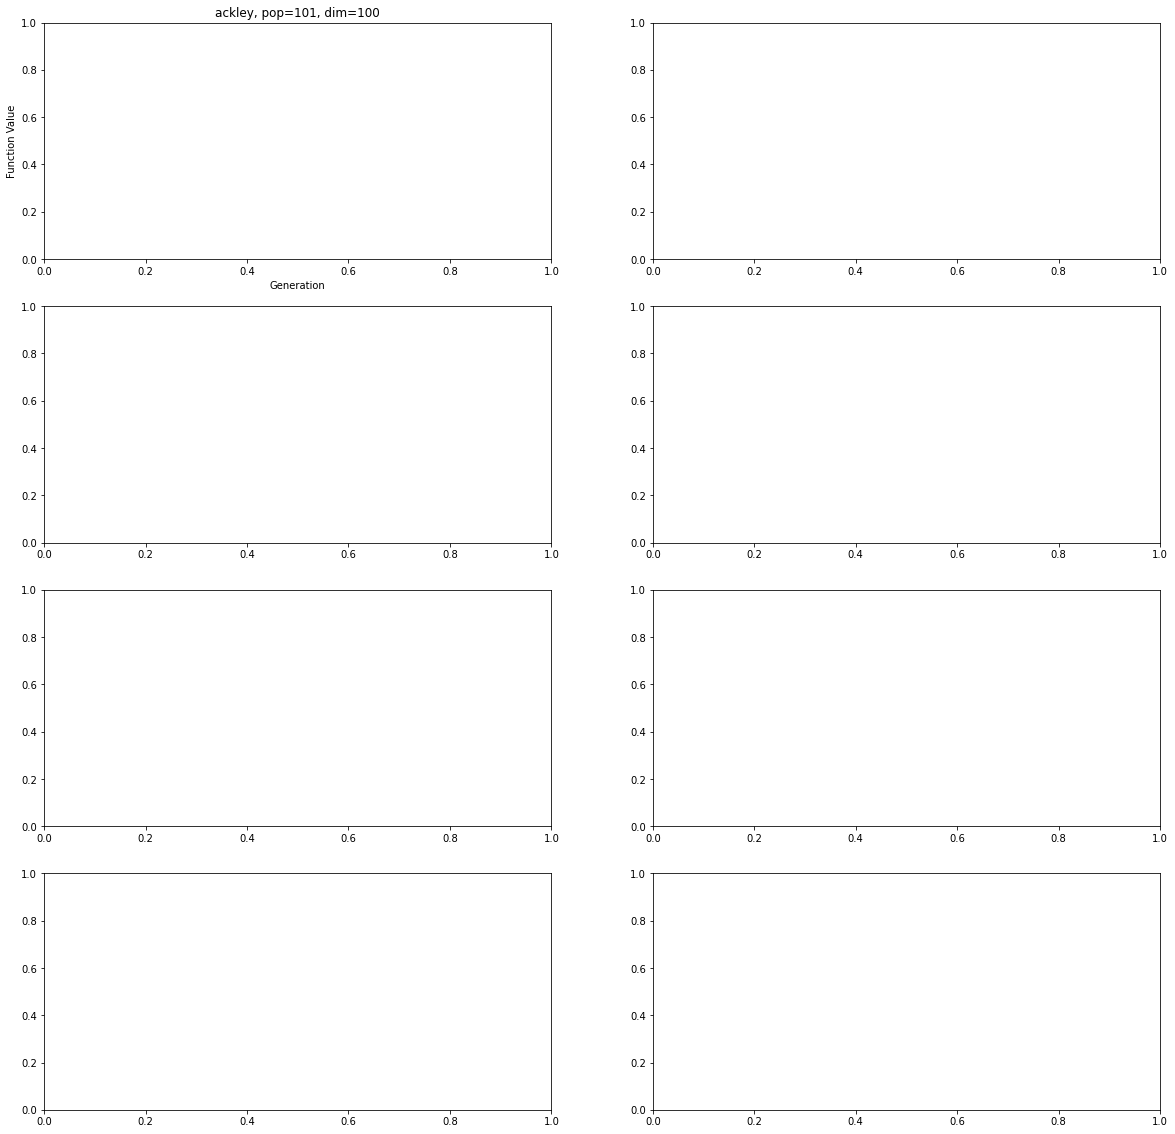

In [15]:
def plot_datas(datas):
    fig, axs = plt.subplots(len(datas), 2, figsize=(20,5*len(datas)))
    for i, (kwargs, data) in enumerate(datas):
        plt.sca(axs[i][0])
        optim_fn, n_pop, n_dim = kwargs['optim_fn'], kwargs['n_pop'], kwargs['n_dim']
        plt.title(f'{optim_fn.__name__}, pop={n_pop}, dim={n_dim}')
        plt.xlabel('Generation');plt.ylabel('Function Value')
        for method_name in method_names:
            viz.plot_mean_std(data[method_name]['fits'], method_name, method_name2color[method_name])
        plt.grid()

        plt.sca(axs[i][1])
        plt.xlabel('Generation');plt.ylabel('Mutation Rate')
        for method_name in method_names:
            viz.plot_mean_std(data[method_name]['mrs'], method_name, method_name2color[method_name], logscale=True)
        plt.grid()
    plt.tight_layout()

plot_datas(datas)

In [53]:
a = torch.randn(100000)

In [58]:
for i in range(10):
    print(i, a.pow(i).mean().item(), a.pow(i).var().item())

0 1.0 0.0
1 0.006928019225597382 0.9961084723472595
2 0.996146559715271 1.9908967018127441
3 0.01924728974699974 14.910150527954102
4 2.983184576034546 95.49579620361328
5 0.08012092113494873 940.28369140625
6 14.910372734069824 10130.5439453125
7 0.6586041450500488 134272.609375
8 104.39423370361328 1975426.125
9 10.7151460647583 32528518.0


100%|██████████| 10/10 [00:36<00:00,  3.66s/it]


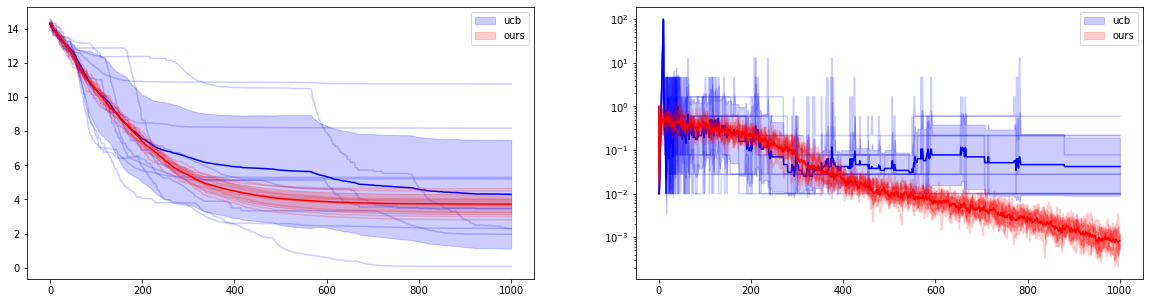

In [6]:

optim_fn = ackley
n_gen = 1000
k=.1

mp1 = viz.MultiPlot()
mp2 = viz.MultiPlot()

for i in tqdm(range(10)):
    do_seed(i)
    pop = torch.randn(101, 100)*6.
    ucb, (pops, fits_ucb, mrs_ucb) = optim.run_evolution_ucb(pop, optim_fn, n_gen, 
                                                       torch.logspace(-2, 2, 10), k=.1)
    pops, fits_ours, mrs_ours, _ = optim.run_evolution_ours(pop, optim_fn, n_gen, k=.5)
    
    mp1.plot(fits_ucb.min(dim=-1).values, 'ucb', c='blue')
    mp1.plot(fits_ours.min(dim=-1).values, 'ours', c='red')
    
    mp2.plot(mrs_ucb, 'ucb', c='blue', logscale=True)
    mp2.plot(mrs_ours[..., 0].log().mean(dim=-1).exp(), 'ours', c='red', logscale=True)
plt.figure(figsize=(20,5))
plt.subplot(121); mp1.render()
plt.subplot(122); mp2.render()

In [174]:
pop = torch.randn(101, 100)*6.
optim_fn = ackley
n_gen = 500

mp = MultiPlot()
for i in range(10):
    for n_mutpop, c in tqdm(zip([1, 2, 4, 5, 10, 20, 25, 50, 100],
                                ['red', 'green', 'blue', 'magenta', 'yellow', 
                                 'pink', 'orange', 'cyan', 'black'])):
        pops, fits_ours, mrs_ours, _ = optim.run_evolution_ours(pop, optim_fn, n_gen, n_mutpop)
        mp.plot(fits_ours.min(dim=-1).values, f'{n_mutpop}', c)
#         plt.plot(fits_ours.min(dim=-1).values, label=f'{n_mutpop}' if i==0 else None)
#     plt.gca().set_prop_cycle(None)
# plt.legend()


9it [00:05,  1.76it/s]
9it [00:03,  2.45it/s]
9it [00:03,  2.43it/s]
9it [00:03,  2.44it/s]
9it [00:04,  2.21it/s]
9it [00:03,  2.44it/s]
9it [00:03,  2.43it/s]
9it [00:03,  2.40it/s]
9it [00:03,  2.39it/s]
9it [00:03,  2.44it/s]


In [213]:
mp.render()

AttributeError: 'MultiPlot' object has no attribute 'render'

X comes from std normal with sigma
$$E[X^n] = \sigma^n (n-1)!$$
$$f(x+\epsilon) - f(x) = \delta(x, \sigma) = \frac{f'(x)}{1!}\epsilon+\frac{f''(x)}{2!}\epsilon^2+\frac{f'''(x)}{3!}\epsilon^3$$
$$E[\delta(x, \sigma)] = \frac{f'(x)}{1!}E[\epsilon]+\frac{f''(x)}{2!}E[\epsilon^2]+\frac{f'''(x)}{3!}E[\epsilon^3]$$
$$E[\delta(x, \sigma)] = \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n!}E[\epsilon^n]$$
$$E[\delta(x, \sigma)] = \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n!}\sigma^n (n-1)!$$
$$E[\delta(x, \sigma)] = \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n}\sigma^n$$




$$f_{\Delta| X, \Sigma}(\delta| x, \sigma)$$
$$f_{\Delta, \Sigma}(\delta, \sigma)$$


$$\epsilon_i\sim N(0, \sigma) \qquad i=0,\dots,q$$
$$\delta_i(x, \sigma) = \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n!}\epsilon_i^n$$
$$E[\delta_i(x, \sigma)] = \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n}\sigma^n$$
$$\min_i \delta_i(x, \sigma)] = 
\delta_\text{min}(x,\sigma) = 
\min_i \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n!}\epsilon_i^n$$
$$E[\delta_\text{min}(x, \sigma)] = $$


$$P(\delta_\text{min} >a) = P(\delta_i > a \quad\forall i)=\Pi_i P(\delta_i>a)$$
$$F_{\delta_\text{min}}(a) = 1-\Pi_i P(\delta_i>a)$$
$$f_{\delta_\text{min}}(a) = -\frac{d}{da} \Pi_i P(\delta_i>a)$$
$$E[\delta_\text{min}] = -\int_{-\infty}^\infty a f_{\delta_\text{min}}(a) da =-\int_{-\infty}^\infty a \frac{d}{da} \left[\Pi_i P(\delta_i>a)\right] da$$

$$\int g(t) f'(t) dt = g(t)\int f'(t)dt - \int g'(t)\int f'(t)dt dt$$
$$\int g(t) f'(t) dt = a\int f'(a)da - \int \int f'(a)da da$$
$$\int g(t) f'(t) dt = af(a) - \int f(a) da$$




$$\int g(t) f'(t) dt = f'(t)\int g(t)dt - \int f''(t)\int g(t)dt dt$$